# Predicting Taxi Fares in NYC

In [123]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Data Import

In [2]:
df = pd.read_csv('../data/NYC_taxi.csv', parse_dates=['pickup_datetime'], nrows=500000)
df.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45+00:00,-74.000964,40.731630,-73.972892,40.758233,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00+00:00,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00+00:00,-73.951300,40.774138,-73.990095,40.751048,1
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00+00:00,-74.006462,40.726713,-73.993078,40.731628,1
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00+00:00,-73.980658,40.733873,-73.991540,40.758138,2


## Data Visualization

In [3]:
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

In [4]:
df2 = df.copy(deep=True)

for long in ['pickup_longitude', 'dropoff_longitude']:
    df2 = df2[(df2[long] > nyc_min_longitude) & (df2[long] < nyc_max_longitude)]

for lat in ['pickup_latitude', 'dropoff_latitude']:
    df2 = df2[(df2[lat] > nyc_min_latitude) & (df2[lat] < nyc_max_latitude)]

df2.shape

(483500, 8)

In [5]:
landmarks = {
    'JFK Airport': (-73.78,40.643),
    'Laguardia Airport': (-73.87, 40.77),
    'Midtown': (-73.98, 40.76),
    'Lower Manhattan': (-74.00, 40.72),
    'Upper Manhattan': (-73.94, 40.82),
    'Brooklyn': (-73.95, 40.66)
}   

In [6]:
def plot_lat_long(df, landmarks, points='Pickup'):
    plt.figure(figsize = (12,12)) # set figure size
    if points == 'pickup':
        plt.plot(list(df.pickup_longitude), list(df.pickup_latitude), '.', markersize=1)
    else:
        plt.plot(list(df.dropoff_longitude), list(df.dropoff_latitude), '.', markersize=1)

    for landmark in landmarks:
        plt.plot(landmarks[landmark][0], landmarks[landmark][1], '*', markersize=15, alpha=1, color='r') # plot landmark location on map
        plt.annotate(landmark, (landmarks[landmark][0]+0.005, landmarks[landmark][1]+0.005), color='r', backgroundcolor='w') # add 0.005 offset on landmark name for aesthetics purposes
  
    plt.title("{} Locations in NYC Illustrated".format(points))
    plt.grid(None)
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.show()

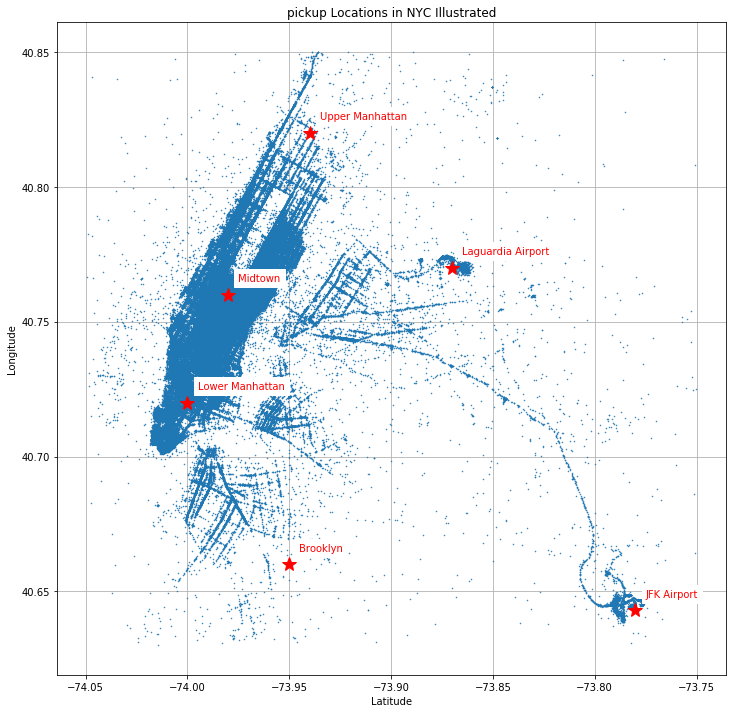

In [7]:
plot_lat_long(df2, landmarks, points='pickup')

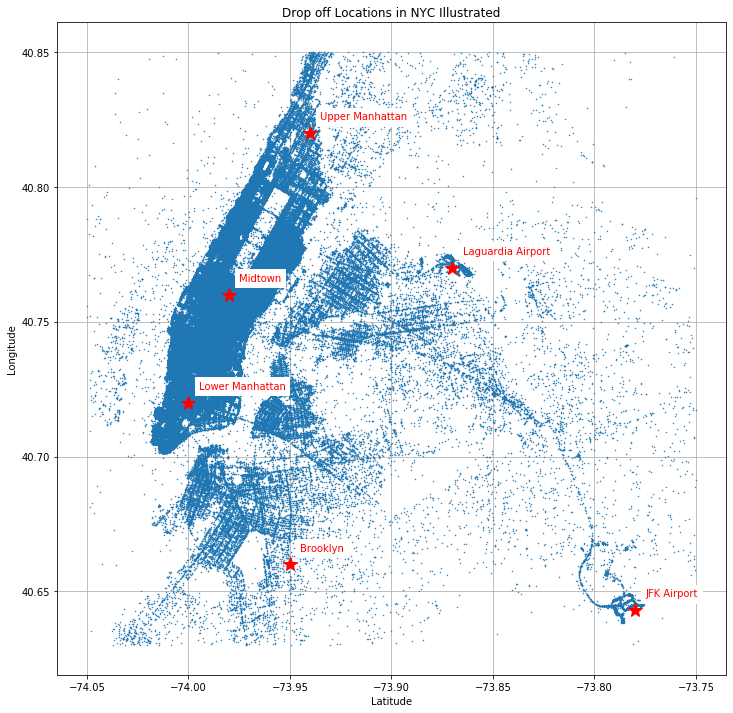

In [8]:
plot_lat_long(df2, landmarks, points='Drop off')

In [9]:
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

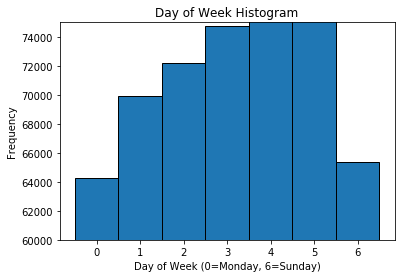

In [10]:
df['day_of_week'].plot.hist(bins=np.arange(8)-0.5, ec='black', ylim=(60000,75000))
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.title('Day of Week Histogram')
plt.show()

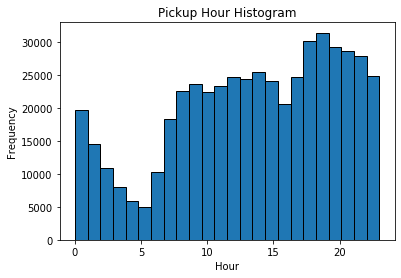

In [11]:
df['hour'].plot.hist(bins=24, ec='black')
plt.title('Pickup Hour Histogram')
plt.xlabel('Hour')
plt.show()

## Data Pre-processing

### Removal of Null Values

In [12]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
year                 0
month                0
day                  0
day_of_week          0
hour                 0
dtype: int64

In [13]:
df = df.dropna()

### Outliers

In [14]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
count,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000
mean,11.358182,-72.520091,39.920350,-72.522435,39.916526,1.683445,2011.739129,6.268617,15.684239,3.042020,13.510843
std,9.916069,11.856446,8.073318,11.797362,7.391002,1.307391,1.860897,3.437798,8.681092,1.949243,6.511596
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992047,40.734916,-73.991382,40.734057,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000


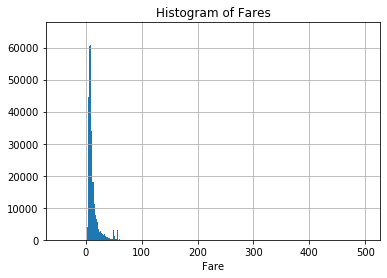

In [15]:
df['fare_amount'].hist(bins=500)
plt.xlabel('Fare')
plt.title('Histogram of Fares')
plt.show()

In [16]:
df = df[(df['fare_amount'] >= 0) & (df['fare_amount'] <= 100)]

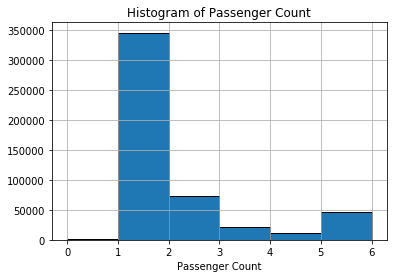

In [17]:
df['passenger_count'].hist(bins=6, ec='black')
plt.xlabel('Passenger Count')
plt.title('Histogram of Passenger Count')
plt.show()

In [18]:
df.loc[df['passenger_count'] == 0, 'passenger_count'] = 1

c:\users\rebs\documents\dev\data-science-env\env\lib\site-packages\pandas\plotting\_matplotlib\core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


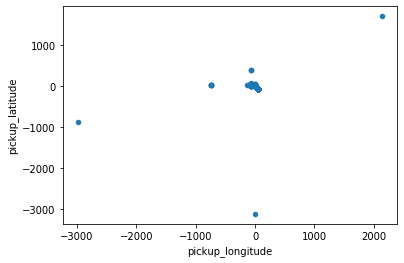

In [19]:
df.plot.scatter('pickup_longitude', 'pickup_latitude')
plt.show()

In [20]:
for long in ['pickup_longitude', 'dropoff_longitude']:
    df = df[(df[long] > nyc_min_longitude) & (df[long] < nyc_max_longitude)]

for lat in ['pickup_latitude', 'dropoff_latitude']:
    df = df[(df[lat] > nyc_min_latitude) & (df[lat] < nyc_max_latitude)]

df.shape

(483438, 13)

## Feature Engineering

In [21]:
df.head()['pickup_datetime']

0   2009-06-15 17:26:21+00:00
1   2010-01-05 16:52:16+00:00
2   2011-08-18 00:35:00+00:00
3   2012-04-21 04:30:42+00:00
4   2010-03-09 07:51:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

In [22]:
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

In [23]:
df.loc[:5, ['pickup_datetime', 'year', 'month', 'day', 'day_of_week', 'hour']]

,pickup_datetime,year,month,day,day_of_week,hour
0,2009-06-15 17:26:21+00:00,2009,6,15,0,17
1,2010-01-05 16:52:16+00:00,2010,1,5,1,16
2,2011-08-18 00:35:00+00:00,2011,8,18,3,0
3,2012-04-21 04:30:42+00:00,2012,4,21,5,4
4,2010-03-09 07:51:00+00:00,2010,3,9,1,7
5,2011-01-06 09:50:45+00:00,2011,1,6,3,9


In [24]:
df = df.drop(['pickup_datetime'], axis=1)

In [25]:
def euc_distance(lat1, long1, lat2, long2):
    return(((lat1-lat2)**2 + (long1-long2)**2)**0.5)

In [26]:
df['travel_distance'] = euc_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

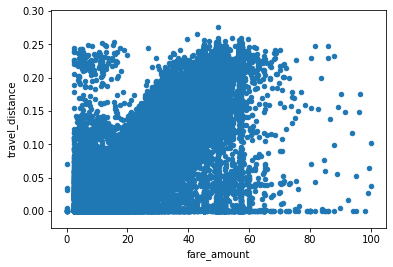

In [27]:
df.plot.scatter('fare_amount', 'travel_distance')
plt.show()

In [28]:
airports = {
    'JFK_Airport': (-73.78, 40.643),
    'Laguardia_Airport': (-73.87, 40.77),
    'Newark_Airport': (-74.18, 40.69)
}

In [29]:
for airport in airports:
    df['pickup_dist_' + airport] = euc_distance(df['pickup_latitude'], df['pickup_longitude'], airports[airport][1], airports[airport][0])
    df['dropoff_dist_' + airport] = euc_distance(df['dropoff_latitude'], df['dropoff_longitude'], airports[airport][1], airports[airport][0])

In [30]:
df[['key', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_dist_JFK_Airport', 'dropoff_dist_JFK_Airport']].head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_dist_JFK_Airport,dropoff_dist_JFK_Airport
0,2009-06-15 17:26:21.0000001,-73.844311,40.721319,-73.841610,40.712278,0.101340,0.092710
1,2010-01-05 16:52:16.0000002,-74.016048,40.711303,-73.979268,40.782004,0.245731,0.242961
2,2011-08-18 00:35:00.00000049,-73.982738,40.761270,-73.991242,40.750562,0.234714,0.237050
3,2012-04-21 04:30:42.0000001,-73.987130,40.733143,-73.991567,40.758092,0.225895,0.240846
4,2010-03-09 07:51:00.000000135,-73.968095,40.768008,-73.956655,40.783762,0.225847,0.225878


In [31]:
df = df.drop(['key'], axis=1)

### Normalization

In [32]:
df_copy = df.copy()

In [33]:
df_scaled = df.drop(['fare_amount'], axis=1)

In [34]:
df_scaled = scale(df_scaled)
df_scaled[:3]

array([[ 3.91689619, -1.12822655,  4.1511158 , -1.36553732, -0.52688821,
        -1.46961077, -0.07818722, -0.07821851, -1.56080055,  0.53544209,
        -0.6464053 , -3.95785399, -4.62806984, -2.32115116, -1.90111909,
         3.49446065,  3.62141698],
       [-1.20346407, -1.51022673, -0.14605462,  1.08347457, -0.52688821,
        -0.93285162, -1.53162467, -1.23017568, -1.04751534,  0.38140754,
         1.2923677 ,  0.65185538,  0.63199555,  1.79154087, -0.07629645,
        -1.40332866,  0.14437401],
       [-0.21032223,  0.39546447, -0.51983833, -0.02087434,  0.23993214,
        -0.39609246,  0.50318775,  0.26736864, -0.02094493, -2.0831452 ,
        -0.52945511,  0.30011018,  0.42507805,  0.01053961,  0.43853778,
        -0.13732977, -0.51913813]])

In [35]:
cols = df.columns.tolist()
cols.remove('fare_amount')
df_scaled = pd.DataFrame(df_scaled, columns=cols, index=df.index)
df_scaled = pd.concat([df_scaled, df['fare_amount']], axis=1)
df = df_scaled.copy()

In [36]:
df.head(10)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,travel_distance,pickup_dist_JFK_Airport,dropoff_dist_JFK_Airport,pickup_dist_Laguardia_Airport,dropoff_dist_Laguardia_Airport,pickup_dist_Newark_Airport,dropoff_dist_Newark_Airport,fare_amount
0,3.916896,-1.128227,4.151116,-1.365537,-0.526888,-1.469611,-0.078187,-0.078219,-1.560801,0.535442,-0.646405,-3.957854,-4.628070,-2.321151,-1.901119,3.494461,3.621417,4.5
1,-1.203464,-1.510227,-0.146055,1.083475,-0.526888,-0.932852,-1.531625,-1.230176,-1.047515,0.381408,1.292368,0.651855,0.631996,1.791541,-0.076296,-1.403329,0.144374,16.9
2,-0.210322,0.395464,-0.519838,-0.020874,0.239932,-0.396092,0.503188,0.267369,-0.020945,-2.083145,-0.529455,0.300110,0.425078,0.010540,0.438538,-0.137330,-0.519138,5.7
3,-0.341270,-0.677271,-0.529984,0.243605,-0.526888,0.140667,-0.659562,0.612956,1.005625,-1.467007,-0.207528,0.018578,0.557964,0.400941,0.412867,-0.482410,-0.456748,7.7
4,0.226261,0.652445,0.559839,1.145221,-0.526888,-0.932852,-0.950250,-0.769393,-1.047515,-1.004903,-0.369533,0.017033,0.033960,-0.590553,-0.964083,0.320629,0.773758,5.3
5,-0.753733,-0.734975,0.052980,0.248557,-0.526888,-0.396092,-1.531625,-1.114980,-0.020945,-0.696834,0.160430,0.407466,-0.007606,0.950478,-0.330923,-0.876481,0.063439,12.1
6,-0.128748,0.029025,0.024574,0.480687,-0.526888,0.140667,1.375250,0.497760,-1.047515,0.997546,-0.504857,0.073461,0.140477,-0.051957,-0.316220,-0.150276,0.101701,7.5
7,0.727006,0.886237,-0.484033,-0.003804,-0.526888,0.140667,-1.531625,-1.345371,-0.534230,0.535442,0.339005,-0.305837,0.397082,-1.261948,0.390151,0.830276,-0.482676,16.5
8,-0.917656,-0.922505,-0.577151,-0.685900,-0.526888,0.140667,1.665938,-1.460567,-1.560801,-0.080696,-0.513343,0.514825,0.205398,1.219432,0.683876,-1.059869,-0.717055,9.0
9,-0.148307,-0.649430,-0.529141,0.245220,0.239932,-1.469611,0.793875,-1.575763,-0.534230,-1.929111,-0.172954,-0.160811,0.557904,0.144356,0.411612,-0.297793,-0.455542,8.9


## Neural Network Modeling

In [38]:
x = df.loc[:, df.columns != 'fare_amount']
y = df.loc[:, 'fare_amount']

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [41]:
model = Sequential()

In [42]:
model.add(Dense(128, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 12,913
Trainable params: 12,913
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [47]:
model.fit(x_train, y_train, epochs=1)

12086/12086 [==============================] - 13s 1ms/step - loss: 14.3953 - mse: 14.3953


## Results

In [53]:
def predict_random(df_prescaled, X_test, model):
    sample = X_test.sample(n=1, random_state=np.random.randint(low=0, high=10000))
    idx = sample.index[0]

    actual_fare = df_prescaled.loc[idx,'fare_amount']
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_of_week = day_names[df_prescaled.loc[idx,'day_of_week']]
    hour = df_prescaled.loc[idx,'hour']
    predicted_fare = model.predict(sample)[0][0]
    rmse = np.sqrt(np.square(predicted_fare-actual_fare))

    print("Trip Details: {}, {}:00hrs".format(day_of_week, hour))  
    print("Actual fare: ${:0.2f}".format(actual_fare))
    print("Predicted fare: ${:0.2f}".format(predicted_fare))
    print("RMSE: ${:0.2f}".format(rmse))

### Random Predictions

In [65]:
predict_random(df_copy, x_test, model)

Trip Details: Sunday, 13:00hrs
Actual fare: $12.10
Predicted fare: $11.49
RMSE: $0.61


In [66]:
predict_random(df_copy, x_test, model)

Trip Details: Sunday, 17:00hrs
Actual fare: $6.90
Predicted fare: $7.58
RMSE: $0.68


In [67]:
predict_random(df_copy, x_test, model)

Trip Details: Saturday, 1:00hrs
Actual fare: $5.00
Predicted fare: $5.20
RMSE: $0.20


### RMSE

In [124]:
train_pred = model.predict(x_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

In [125]:
test_pred = model.predict(x_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

In [126]:
print('Train RMSE: {:0.2f}'.format(train_rmse))
print('Test RMSE: {:0.2f}'.format(test_rmse))

Train RMSE: 3.58
Test RMSE: 3.57
